По каждому из классов (business, entertainment, politics, sport, tech) вам необходимо взять каждый класс и смоделировать распределение топиков (тем) по каждому из классов и построить визуализации. Необходимо объяснить о чем больше всего говорится в каждом из классов, то есть сделать на основании вашей работы анализ по каждому из классов. Используем любой подход, который вам известен для задачи Topic Modelling. 


In [2]:
import numpy as np
import pandas as pd
import textwrap
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pymorphy3
import string
import warnings
import re
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel


nltk.download('stopwords')
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("wordnet")
warnings.filterwarnings("ignore")
DATA_DIR = "D:/bbc"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
class BbcDataset:
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = data_dir
        self.documents = [
            os.path.join(path, name)
            for path, _, files in os.walk(self.data_dir)
            for name in files
        ]
        self.lemmatizer = WordNetLemmatizer()
        self.vectorizer = TfidfVectorizer(
            stop_words="english",
            norm="l1",
            preprocessor=self.preprocess_text,
        )

        self.dataframe = self.get_pandas_alike_dataset()

    def preprocess_text(self, text: str) -> str:
        """
        Удаляет все, кроме английских букв нижнего регистра и пробелов, затем лемматизирует

        :param text: Текст для обработки
        :return: Обработанная строка текста
        """
        text = re.sub(r"[^a-z\s]", "", text.lower())
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return " ".join(tokens)

    def get_dataset(self):
        """Загружает все документы и их категории"""
        data = []
        for file in self.documents:
            label = os.path.basename(os.path.dirname(file))
            try:
                with open(file, "r", encoding="utf-8") as f:
                    content = f.read().strip()
                data.append((content, label))
            except Exception as e:
                print(f"Ошибка чтения файла {file}: {e}")
        return data

    def get_pandas_alike_dataset(self):
        """Возвращает DataFrame с текстами и метками"""
        data = self.get_dataset()
        return pd.DataFrame(data, columns=["text", "label"])

   
    

In [4]:
bbc_dataset = BbcDataset()

Ошибка чтения файла D:/bbc\pytorch_distilbert_news.bin: 'utf-8' codec can't decode byte 0x80 in position 128: invalid start byte
Ошибка чтения файла D:/bbc\sport\199.txt: 'utf-8' codec can't decode byte 0xa3 in position 257: invalid start byte


In [5]:
data = bbc_dataset.get_pandas_alike_dataset()

Ошибка чтения файла D:/bbc\pytorch_distilbert_news.bin: 'utf-8' codec can't decode byte 0x80 in position 128: invalid start byte
Ошибка чтения файла D:/bbc\sport\199.txt: 'utf-8' codec can't decode byte 0xa3 in position 257: invalid start byte


In [6]:
data

text     label
0     [PAD]\n[unused1]\n[unused2]\n[unused3]\n[unuse...       bbc
1     Ad sales boost Time Warner profit\n\nQuarterly...  business
2     Dollar gains on Greenspan speech\n\nThe dollar...  business
3     Yukos unit buyer faces loan claim\n\nThe owner...  business
4     High fuel prices hit BA's profits\n\nBritish A...  business
...                                                 ...       ...
2216  BT program to beat dialler scams\n\nBT is intr...      tech
2217  Spam e-mails tempt net shoppers\n\nComputer us...      tech
2218  Be careful how you code\n\nA new European dire...      tech
2219  US cyber security chief resigns\n\nThe man mak...      tech
2220  Losing yourself in online gaming\n\nOnline rol...      tech

[2221 rows x 2 columns]

Подготовка документа

In [8]:
m = pymorphy3.MorphAnalyzer()
mystopwords = stopwords.words('english')
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        text = re.sub(r'[^A-Za-z ]', '', text.lower())
        return " ".join([token for token in text.split() if token.lower() not in mystopwords])
    except Exception as e:
        return ""

def lemmatize(text, morph=m):
    try:
        return " ".join([morph.parse(word)[0].normal_form for word in text.split()])
    except:
        return ""

def remove_stoplemmas(text):
    try:
        return " ".join([token for token in text.split()])
    except:
        return ""

In [9]:
data.text = data.text.apply(remove_stopwords) 
data.text = data.text.apply(lemmatize)
data.text = data.text.apply(remove_stoplemmas) 


In [10]:
data

text     label
0     padunusedunusedunusedunusedunusedunusedunusedu...       bbc
1     ad sales boost time warner profitquarterly pro...  business
2     dollar gains greenspan speechthe dollar hit hi...  business
3     yukos unit buyer faces loan claimthe owners em...  business
4     high fuel prices hit bas profitsbritish airway...  business
...                                                 ...       ...
2216  bt program beat dialler scamsbt introducing tw...      tech
2217  spam emails tempt net shopperscomputer users a...      tech
2218  careful codea new european directive could put...      tech
2219  us cyber security chief resignsthe man making ...      tech
2220  losing online gamingonline role playing games ...      tech

[2221 rows x 2 columns]

In [11]:
data.info()
data.groupby('label').count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2221 non-null   object
 1   label   2221 non-null   object
dtypes: object(2)
memory usage: 34.8+ KB


text
label              
bbc               1
business        506
entertainment   386
politics        417
sport           510
tech            401

In [12]:
data_bus = data.query('label=="business"')
data_ent = data.query('label=="entertainment"')
data_pol = data.query('label=="politics"')
data_sp = data.query('label=="sport"')
data_tech = data.query('label=="tech"')


In [13]:
data_bus.shape, data_ent.shape, data_pol.shape, data_sp.shape, data_tech.shape

((506, 2), (386, 2), (417, 2), (510, 2), (401, 2))

Создаем словарь и получаем векторно представление по каждому классу

In [15]:
from gensim.corpora import *
from gensim.corpora import Dictionary

In [16]:
texts_bus = [data_bus.text.iloc[i].split() for i in range(len(data_bus))]
dictionary_bus = Dictionary(texts_bus)
corpus_bus = [dictionary_bus.doc2bow(text) for text in texts_bus]

In [17]:
texts_ent = [data_ent.text.iloc[i].split() for i in range(len(data_ent))]
dictionary_ent = Dictionary(texts_ent)
corpus_ent = [dictionary_ent.doc2bow(text) for text in texts_ent]

In [18]:
texts_pol = [data_pol.text.iloc[i].split() for i in range(len(data_pol))]
dictionary_pol = Dictionary(texts_pol)
corpus_pol = [dictionary_pol.doc2bow(text) for text in texts_pol]

In [19]:
texts_sp = [data_sp.text.iloc[i].split() for i in range(len(data_sp))]
dictionary_sp = Dictionary(texts_sp)
corpus_sp = [dictionary_sp.doc2bow(text) for text in texts_sp]

In [20]:
texts_tech = [data_tech.text.iloc[i].split() for i in range(len(data_tech))]
dictionary_tech = Dictionary(texts_tech)
corpus_tech = [dictionary_tech.doc2bow(text) for text in texts_tech]

Вычисление сходства по косинусной мере на векторах tf-idf по каждому классу

In [22]:
#создаем новый корпус на основе tf idf

from gensim.models import  *
from gensim import similarities

tfidf_bus = TfidfModel(corpus_bus)
corpus_tfidf_bus = tfidf_bus[corpus_bus]

index_bus = similarities.MatrixSimilarity(corpus_tfidf_bus)
sims_bus = index_bus[corpus_tfidf_bus]


tfidf_ent = TfidfModel(corpus_ent)
corpus_tfidf_ent = tfidf_ent[corpus_ent]

index_ent = similarities.MatrixSimilarity(corpus_tfidf_ent)
sims_ent = index_ent[corpus_tfidf_ent]


tfidf_pol = TfidfModel(corpus_pol)
corpus_tfidf_pol = tfidf_pol[corpus_pol]

index_pol = similarities.MatrixSimilarity(corpus_tfidf_pol)
sims_pol = index_pol[corpus_tfidf_pol]


tfidf_sp = TfidfModel(corpus_sp)
corpus_tfidf_sp = tfidf_sp[corpus_sp]

index_sp = similarities.MatrixSimilarity(corpus_tfidf_sp)
sims_sp = index_sp[corpus_tfidf_sp]


tfidf_tech = TfidfModel(corpus_tech)
corpus_tfidf_tech = tfidf_tech[corpus_tech]

index_tech = similarities.MatrixSimilarity(corpus_tfidf_tech)
sims_tech = index_tech[corpus_tfidf_tech]



Сформируем матрицу близости слов внутри каждого класса. Матрица близости предложений

По диагонали расположены тесты "сами с собой", по диагонали видим 1 в sims_XXX. 
Ниже и выше диагонали связь текста с текстом по расстоянию. На картинке видно, что ничего не связано с друг другом (незначительные проблески на картинке).
Необходимо использовать Topic modeling

In [25]:
from pylab import pcolor, show, colorbar, xticks, yticks
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


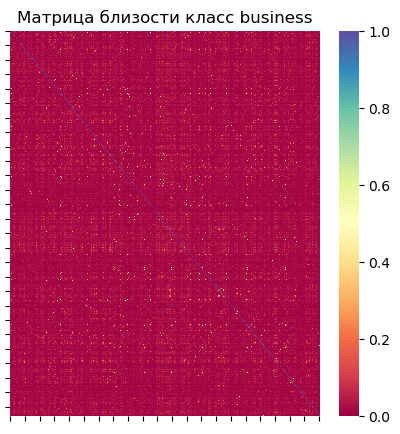

In [26]:
plt.figure(figsize = (5,5))
sns.heatmap(data=sims_bus, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости класс business")
plt.show()

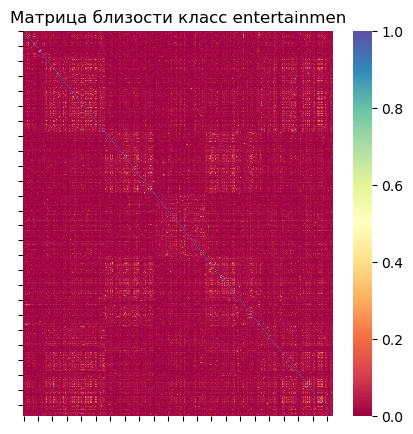

In [27]:
plt.figure(figsize = (5,5))
sns.heatmap(data=sims_ent, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости класс entertainmen")
plt.show()

In [28]:
sims_ent

array([[1.0000001e+00, 5.5833901e-03, 6.7272587e-03, ..., 3.8620564e-03,
        7.8547150e-03, 3.2300854e-04],
       [5.5833901e-03, 1.0000001e+00, 5.9528169e-03, ..., 9.4240075e-03,
        7.0898565e-03, 5.9199883e-03],
       [6.7272587e-03, 5.9528169e-03, 9.9999994e-01, ..., 1.6891880e-02,
        3.4069948e-02, 1.7808819e-02],
       ...,
       [3.8620564e-03, 9.4240075e-03, 1.6891880e-02, ..., 1.0000001e+00,
        4.5710165e-02, 1.1069036e-02],
       [7.8547150e-03, 7.0898565e-03, 3.4069948e-02, ..., 4.5710165e-02,
        1.0000000e+00, 2.3690253e-02],
       [3.2300854e-04, 5.9199883e-03, 1.7808819e-02, ..., 1.1069036e-02,
        2.3690253e-02, 1.0000000e+00]], dtype=float32)

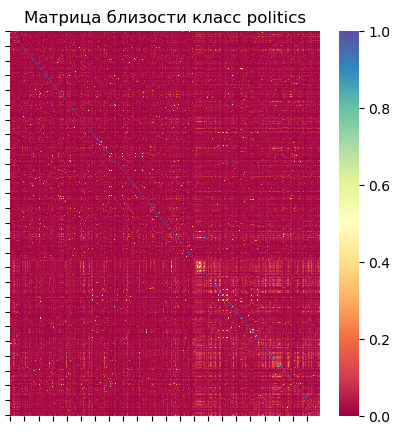

In [29]:
plt.figure(figsize = (5,5))
sns.heatmap(data=sims_pol, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости класс politics")
plt.show()

In [30]:
sims_pol

array([[1.0000001 , 0.0196155 , 0.3058583 , ..., 0.02380612, 0.04096194,
        0.05310357],
       [0.0196155 , 1.0000002 , 0.00447032, ..., 0.01149731, 0.03000348,
        0.0386248 ],
       [0.3058583 , 0.00447032, 1.0000002 , ..., 0.01991437, 0.01785811,
        0.02206809],
       ...,
       [0.02380612, 0.01149731, 0.01991437, ..., 0.9999998 , 0.06525836,
        0.05996458],
       [0.04096194, 0.03000348, 0.01785811, ..., 0.06525836, 1.        ,
        0.20550063],
       [0.05310357, 0.0386248 , 0.02206809, ..., 0.05996458, 0.20550063,
        1.0000001 ]], dtype=float32)

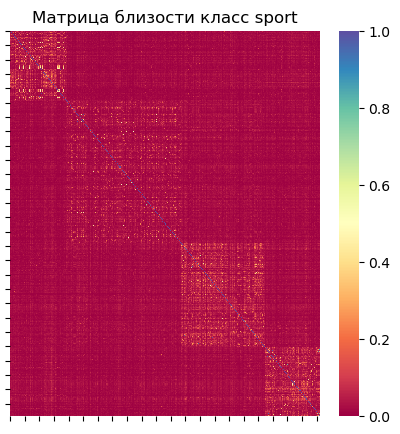

In [31]:
plt.figure(figsize = (5,5))
sns.heatmap(data=sims_sp, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости класс sport")
plt.show()

In [32]:
sims_sp

array([[0.9999996 , 0.03547755, 0.0478372 , ..., 0.00338074, 0.01659909,
        0.00579769],
       [0.03547755, 1.        , 0.01306829, ..., 0.00810505, 0.00941265,
        0.00370446],
       [0.0478372 , 0.01306829, 1.0000002 , ..., 0.01788911, 0.02672449,
        0.02713309],
       ...,
       [0.00338074, 0.00810505, 0.01788911, ..., 0.99999994, 0.01036367,
        0.27911118],
       [0.01659909, 0.00941265, 0.02672449, ..., 0.01036367, 1.        ,
        0.04872476],
       [0.00579769, 0.00370446, 0.02713309, ..., 0.27911118, 0.04872476,
        1.        ]], dtype=float32)

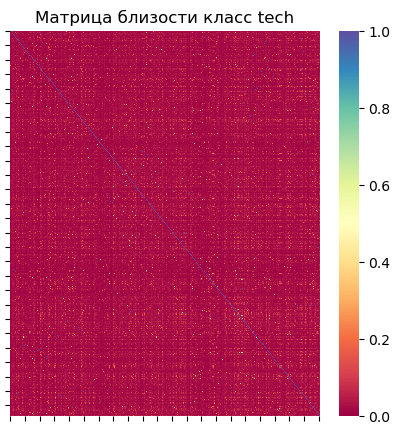

In [33]:
plt.figure(figsize = (5,5))
sns.heatmap(data=sims_tech, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости класс tech")
plt.show()

In [34]:
sims_tech

array([[0.99999994, 0.01505065, 0.00773814, ..., 0.02313513, 0.00790535,
        0.02175345],
       [0.01505065, 0.99999994, 0.00824536, ..., 0.03065029, 0.01279435,
        0.04648306],
       [0.00773814, 0.00824536, 0.9999999 , ..., 0.03027212, 0.04071284,
        0.01745439],
       ...,
       [0.02313513, 0.03065029, 0.03027212, ..., 1.0000001 , 0.0295041 ,
        0.04712778],
       [0.00790535, 0.01279435, 0.04071284, ..., 0.0295041 , 0.99999994,
        0.01439009],
       [0.02175345, 0.04648306, 0.01745439, ..., 0.04712778, 0.01439009,
        1.        ]], dtype=float32)

Класс business

Построим гистограмму слов часто встречающихся в тексте. 
При анализе гистрограммы видим, часто встречающиеся слова относятся к классу business: market, company, economy, sales, oil 

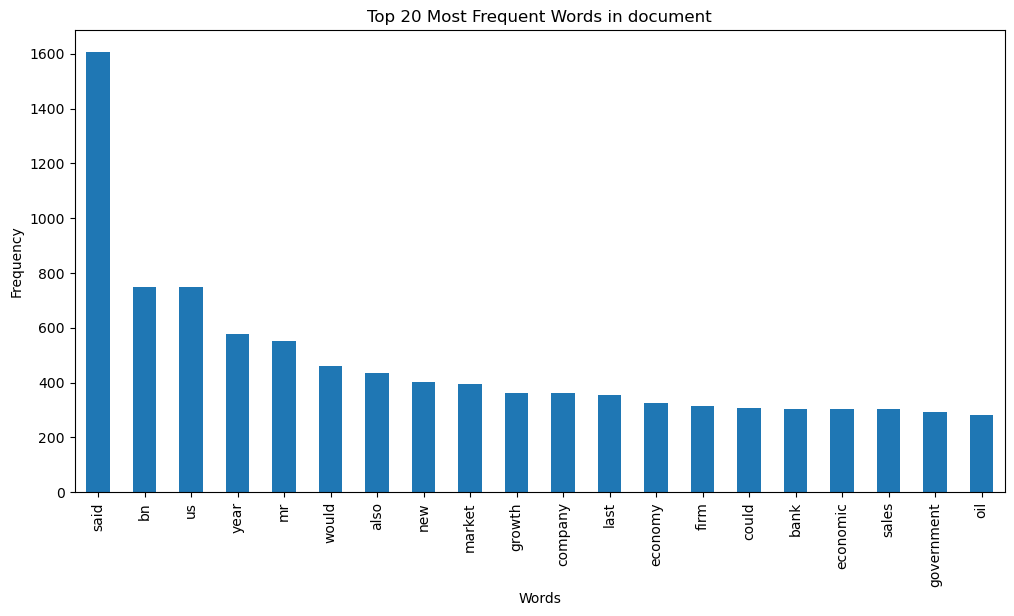

In [37]:
all_words = pd.Series(' '.join(data_bus['text']).lower().split())
word_counts = all_words.value_counts().sort_values(ascending=False)

num_words_to_visualize = 20

plt.figure(figsize=(12, 6))
word_counts.head(num_words_to_visualize).plot(kind='bar')
plt.title(f'Top {num_words_to_visualize} Most Frequent Words in document')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [38]:
# находим оценку согласованности с разным количеством тем, рассматриваем от 2-14 тем  и не ниже 0.4
for i in range(2,15):
    lsi = LsiModel(corpus_bus, num_topics=i, id2word=dictionary_bus)
    coherence_model = CoherenceModel(model=lsi, texts=texts_bus, dictionary=dictionary_bus, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.4604065116941685
Coherence score with 3 clusters: 0.4254945984534742
Coherence score with 4 clusters: 0.4899534870442433
Coherence score with 5 clusters: 0.45505864642925375
Coherence score with 6 clusters: 0.3802727403407455
Coherence score with 7 clusters: 0.38056121468509857
Coherence score with 8 clusters: 0.41157666658349135
Coherence score with 9 clusters: 0.3574196234588565
Coherence score with 10 clusters: 0.3635960642450512
Coherence score with 11 clusters: 0.34258058674940045
Coherence score with 12 clusters: 0.36815190870754466
Coherence score with 13 clusters: 0.34901943462224067
Coherence score with 14 clusters: 0.33956278564308234


Наибольшая согласованность тем при 4 кластерах. Для анализа будем брать - 5

In [40]:
%%time
lsi_bus = lsimodel.LsiModel(corpus=corpus_tfidf_bus, id2word=dictionary_bus, num_topics=5)

CPU times: total: 1.09 s
Wall time: 443 ms


Сформировано 5 кластеров. Чем выше число слова, тем выше распределение слова по теме.
При анализе тем в кластере видим в новостях идет речь о нефтяной коспании Юкос, ее деятельности и банкроствсве, Газпром, Юганск, Роснефть (кластер 0, 1, 2). По кластеру 3 и 4 в новостях речь о скандале WorldCom и Салливане

In [41]:
lsi_bus.show_topics(5)

[(0,
  '-0.134*"yukos" + -0.116*"economy" + -0.114*"growth" + -0.108*"us" + -0.107*"oil" + -0.103*"bn" + -0.101*"sales" + -0.100*"dollar" + -0.099*"bank" + -0.098*"economic"'),
 (1,
  '-0.488*"yukos" + -0.230*"russian" + -0.199*"gazprom" + -0.181*"yugansk" + -0.165*"court" + -0.164*"rosneft" + -0.137*"auction" + -0.128*"khodorkovsky" + -0.124*"bankruptcy" + -0.120*"oil"'),
 (2,
  '0.378*"lse" + 0.319*"boerse" + 0.255*"deutsche" + 0.226*"euronext" + -0.189*"yukos" + 0.169*"offer" + 0.162*"bid" + 0.115*"london" + 0.109*"takeover" + 0.108*"stock"'),
 (3,
  '-0.319*"ebbers" + 0.266*"lse" + 0.227*"boerse" + 0.212*"deutsche" + -0.209*"sullivan" + -0.206*"worldcom" + 0.158*"euronext" + -0.156*"mci" + -0.155*"mr" + 0.144*"yukos"'),
 (4,
  '0.303*"ebbers" + 0.199*"sullivan" + 0.192*"worldcom" + -0.150*"dollar" + 0.144*"mci" + -0.126*"deficit" + 0.123*"fraud" + 0.114*"rates" + -0.108*"eu" + -0.104*"budget"')]

In [42]:
lsi_bus[corpus_tfidf_bus]

После применения LSI видим на матрице, что много слов связаны друг с другом. Значение связи стремится к 1

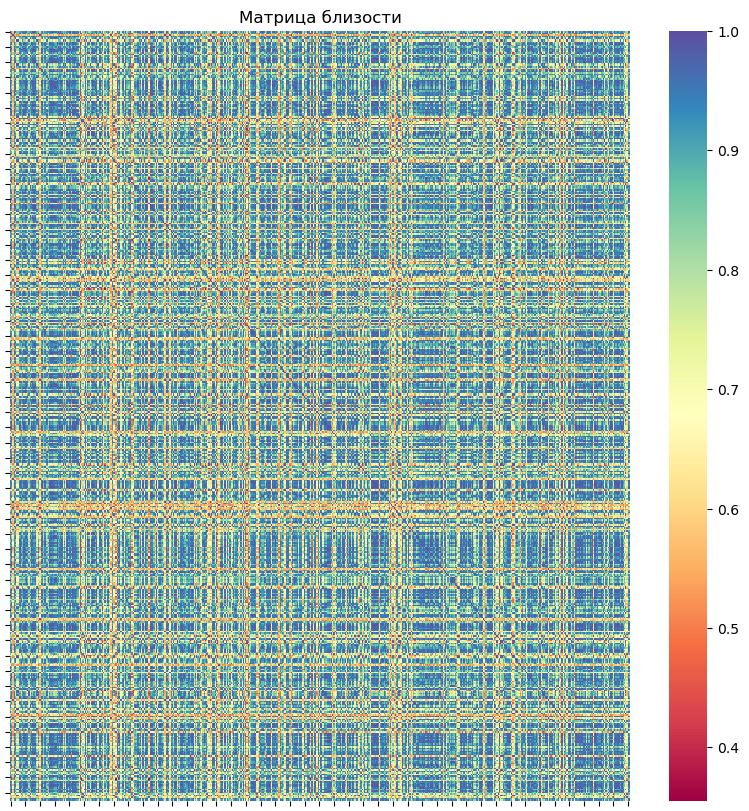

In [43]:
corpus_lsi_bus = lsi_bus[corpus_tfidf_bus] # каждый документ будет представлен в виде вектора, который характеризует его составность по темам.
index_bus_new = similarities.MatrixSimilarity(corpus_lsi_bus) #индекс для вычисления сходства между всеми документами в пространстве тем.
sims_bus_new = index_bus_new[corpus_lsi_bus]
sims_bus_new  = (sims_bus_new + 1)/2.

plt.figure(figsize = (10,10))
sns.heatmap(data=sims_bus_new, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

Класс entertainment

Построим гистограмму слов часто встречающихся в тексте. 
При анализе гистрограммы видим, часто встречающиеся слова относятся к классу entertainment: music, show, awards, films

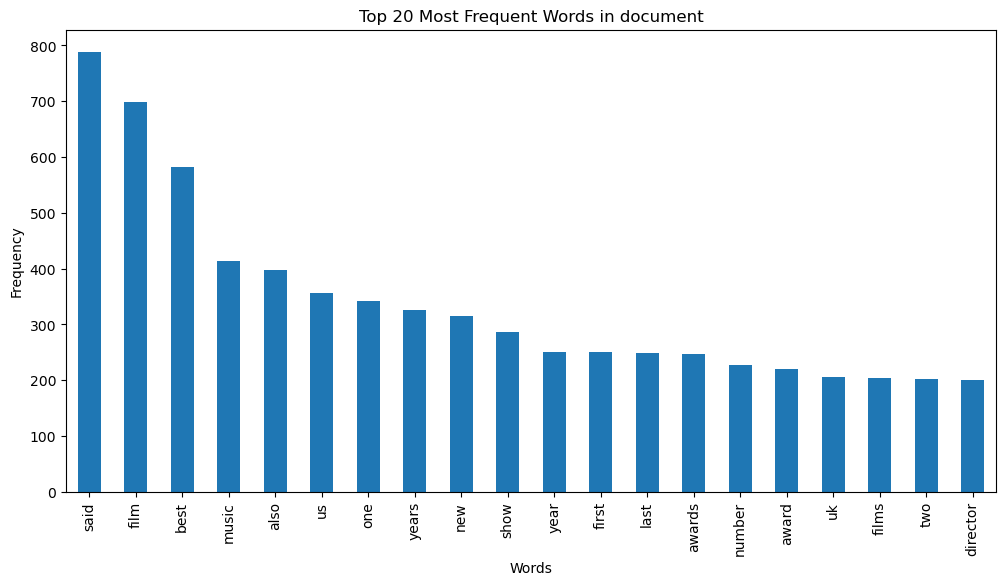

In [46]:
all_words = pd.Series(' '.join(data_ent['text']).lower().split())
word_counts = all_words.value_counts().sort_values(ascending=False)

num_words_to_visualize = 20

plt.figure(figsize=(12, 6))
word_counts.head(num_words_to_visualize).plot(kind='bar')
plt.title(f'Top {num_words_to_visualize} Most Frequent Words in document')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [47]:
# находим оценку согласованности с разным количеством тем
for i in range(2,15):
    lsi = LsiModel(corpus_ent, num_topics=i, id2word=dictionary_ent)
    coherence_model = CoherenceModel(model=lsi, texts=texts_ent, dictionary=dictionary_ent, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.5170909852082788
Coherence score with 3 clusters: 0.5468708753404598
Coherence score with 4 clusters: 0.388565497895304
Coherence score with 5 clusters: 0.49878022565544367
Coherence score with 6 clusters: 0.33973626615475566
Coherence score with 7 clusters: 0.4307207924669428
Coherence score with 8 clusters: 0.42578248316198153
Coherence score with 9 clusters: 0.35825243356669384
Coherence score with 10 clusters: 0.39511017487731753
Coherence score with 11 clusters: 0.4137135836313491
Coherence score with 12 clusters: 0.38814507674640614
Coherence score with 13 clusters: 0.3994285515814581
Coherence score with 14 clusters: 0.3704432832522911


Наибольшая согласованность тем при 3 кластерах. Для анализа будем брать - 7

Сформировано 7 кластеров. Чем выше число слова, тем выше распределение слова по теме.
При анализе тем в кластере видим в новостях идет речь о музыкальной премии, наградах(кластер 0, 1, 2). 3 кластер - о фильме "знакомствос Фокерами", актре, котрорый там снимался Де Ниро. По кластеру 3 и 4 о международном кинофестивале в Берлине. 5 кластер - о фильме Код Да Винчи и актерах, которые там играли Тоту, Хэнкс

In [49]:
%%time
lsi_ent = lsimodel.LsiModel(corpus=corpus_tfidf_ent, id2word=dictionary_ent, num_topics=7)

CPU times: total: 1.33 s
Wall time: 467 ms


In [50]:
lsi_ent.show_topics(7)

[(0,
  '0.221*"best" + 0.157*"film" + 0.114*"number" + 0.111*"awards" + 0.097*"award" + 0.094*"album" + 0.089*"music" + 0.089*"top" + 0.089*"aviator" + 0.088*"band"'),
 (1,
  '-0.221*"best" + 0.177*"chart" + 0.171*"number" + 0.158*"album" + 0.148*"band" + -0.140*"aviator" + -0.130*"swank" + -0.127*"foxx" + 0.120*"music" + 0.119*"singles"'),
 (2,
  '-0.245*"box" + -0.212*"fockers" + -0.203*"office" + -0.201*"number" + -0.181*"meet" + -0.153*"niro" + -0.150*"weekend" + -0.129*"chart" + -0.122*"de" + -0.119*"takings"'),
 (3,
  '-0.223*"best" + 0.191*"festival" + -0.182*"album" + -0.149*"number" + 0.126*"film" + -0.121*"chart" + 0.118*"films" + -0.113*"band" + 0.106*"box" + -0.104*"singles"'),
 (4,
  '0.339*"festival" + 0.168*"berlin" + 0.146*"daylewis" + -0.120*"show" + 0.111*"number" + 0.101*"european" + 0.099*"film" + 0.094*"wham" + 0.090*"films" + 0.089*"berlinale"'),
 (5,
  '-0.335*"download" + -0.323*"chart" + -0.201*"sales" + -0.195*"singles" + -0.169*"downloads" + -0.161*"bpi" + -0

In [51]:
lsi_ent[corpus_tfidf_ent]

После применения LSI видим на матрице, что много слов связаны друг с другом. Матрица почти вся синяя. Значение связи стремится к 1

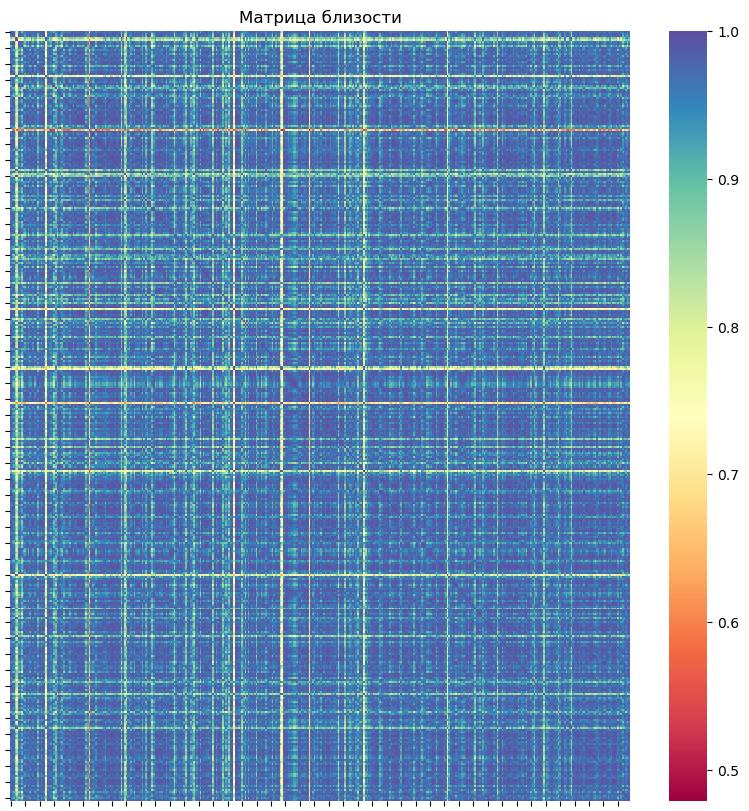

In [52]:
corpus_lsi_ent = lsi_bus[corpus_tfidf_ent] # каждый документ будет представлен в виде вектора, который характеризует его составность по темам.
index_ent_new = similarities.MatrixSimilarity(corpus_lsi_ent) #индекс для вычисления сходства между всеми документами в пространстве тем.
sims_ent_new = index_ent_new[corpus_lsi_ent]
sims_ent_new  = (sims_ent_new + 1)/2.

plt.figure(figsize = (10,10))
sns.heatmap(data=sims_ent_new, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

Класс politics

Построим гистограмму слов часто встречающихся в тексте. 
При анализе гистрограммы видим, часто встречающиеся слова относятся к классу politics:goverment, labour, minister, public

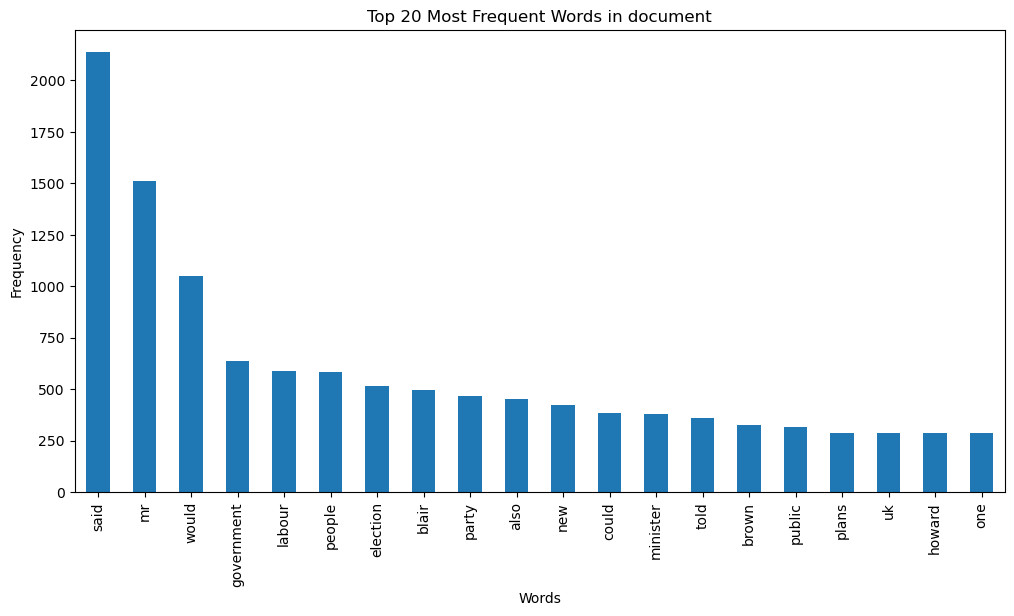

In [55]:
all_words = pd.Series(' '.join(data_pol['text']).lower().split())
word_counts = all_words.value_counts().sort_values(ascending=False)

num_words_to_visualize = 20

plt.figure(figsize=(12, 6))
word_counts.head(num_words_to_visualize).plot(kind='bar')
plt.title(f'Top {num_words_to_visualize} Most Frequent Words in document')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [56]:
# находим оценку согласованности с разным количеством тем
for i in range(2,15):
    lsi = LsiModel(corpus_pol, num_topics=i, id2word=dictionary_pol)
    coherence_model = CoherenceModel(model=lsi, texts=texts_pol, dictionary=dictionary_pol, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.3807331508859245
Coherence score with 3 clusters: 0.4026322042685604
Coherence score with 4 clusters: 0.39461203615841345
Coherence score with 5 clusters: 0.44088717689775175
Coherence score with 6 clusters: 0.5028097336439376
Coherence score with 7 clusters: 0.42592675143203446
Coherence score with 8 clusters: 0.44399510181589275
Coherence score with 9 clusters: 0.4225199084046517
Coherence score with 10 clusters: 0.3679538166232742
Coherence score with 11 clusters: 0.3683551849061569
Coherence score with 12 clusters: 0.37082343383699423
Coherence score with 13 clusters: 0.3590996592860821
Coherence score with 14 clusters: 0.3787624110745188


Наибольшая согласованность тем при 6 кластерах. Для анализа будем брать - 9

Сформировано 9 кластеров. Чем выше число слова, тем выше распределение слова по теме.
По классу политика сложно разбить класс на подтемы, так как многие слова встераются во всех кластерах. В классе идет речь о труде, рабочих, налогах, законодательстве


In [58]:
%%time
lsi_pol = lsimodel.LsiModel(corpus=corpus_tfidf_pol, id2word=dictionary_pol, num_topics=9)

CPU times: total: 1.06 s
Wall time: 493 ms


In [59]:
lsi_pol.show_topics(9)

[(0,
  '0.158*"brown" + 0.143*"tax" + 0.132*"blair" + 0.119*"election" + 0.114*"labour" + 0.110*"howard" + 0.099*"party" + 0.094*"mr" + 0.093*"chancellor" + 0.082*"prime"'),
 (1,
  '0.237*"brown" + 0.205*"tax" + -0.179*"lords" + -0.143*"law" + -0.138*"lord" + -0.134*"trial" + -0.134*"rights" + -0.132*"suspects" + -0.121*"human" + -0.118*"clarke"'),
 (2,
  '0.504*"ukip" + 0.414*"kilroysilk" + 0.162*"veritas" + 0.157*"eu" + 0.147*"houston" + -0.124*"tax" + 0.121*"hockney" + -0.117*"id" + 0.099*"party" + 0.095*"robert"'),
 (3,
  '-0.249*"brown" + 0.223*"tax" + -0.176*"blair" + -0.170*"book" + 0.167*"id" + -0.149*"lord" + 0.130*"cards" + 0.128*"ukip" + 0.117*"kilroysilk" + -0.115*"prime"'),
 (4,
  '-0.295*"id" + 0.239*"unions" + 0.226*"workers" + -0.223*"cards" + 0.221*"pension" + 0.141*"sector" + 0.140*"union" + 0.131*"eu" + 0.119*"choice" + 0.106*"strike"'),
 (5,
  '0.303*"id" + 0.226*"unions" + 0.224*"cards" + 0.207*"pension" + 0.205*"workers" + -0.177*"eu" + -0.148*"tax" + 0.138*"presc

In [60]:
lsi_pol[corpus_tfidf_pol]

После применения LSI видим на матрице, видно что большинство слов связаны друг с дргом

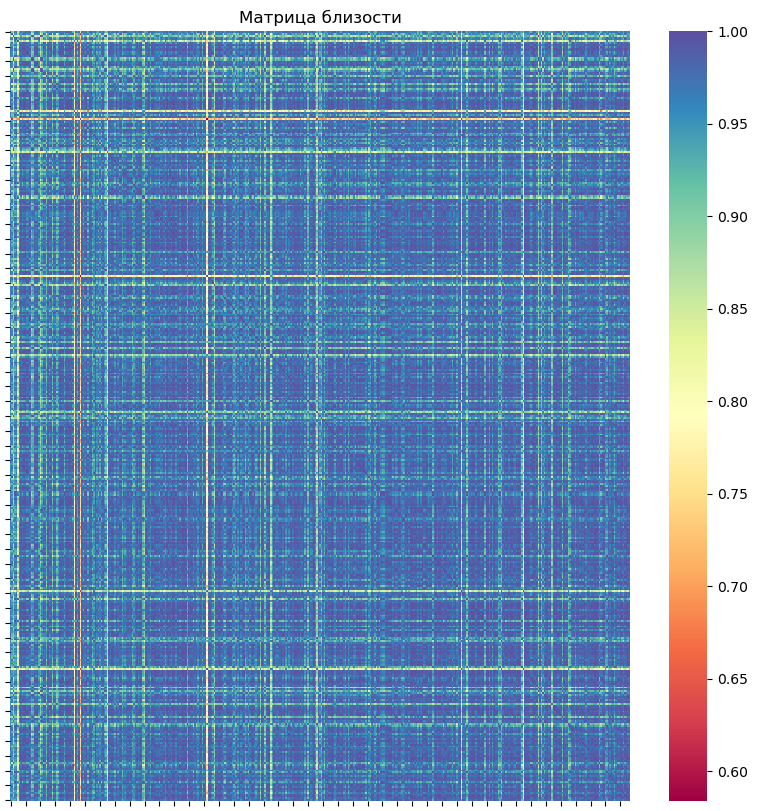

In [61]:
corpus_lsi_pol = lsi_bus[corpus_tfidf_pol] # каждый документ будет представлен в виде вектора, который характеризует его составность по темам.
index_pol_new = similarities.MatrixSimilarity(corpus_lsi_pol) #индекс для вычисления сходства между всеми документами в пространстве тем.
sims_pol_new = index_pol_new[corpus_lsi_pol]
sims_pol_new  = (sims_pol_new + 1)/2.

plt.figure(figsize = (10,10))
sns.heatmap(data=sims_pol_new, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

Класс sport

Построим гистограмму слов часто встречающихся в тексте. 
При анализе гистрограммы видим, часто встречающиеся слова относятся к классу politics: players, team, cup

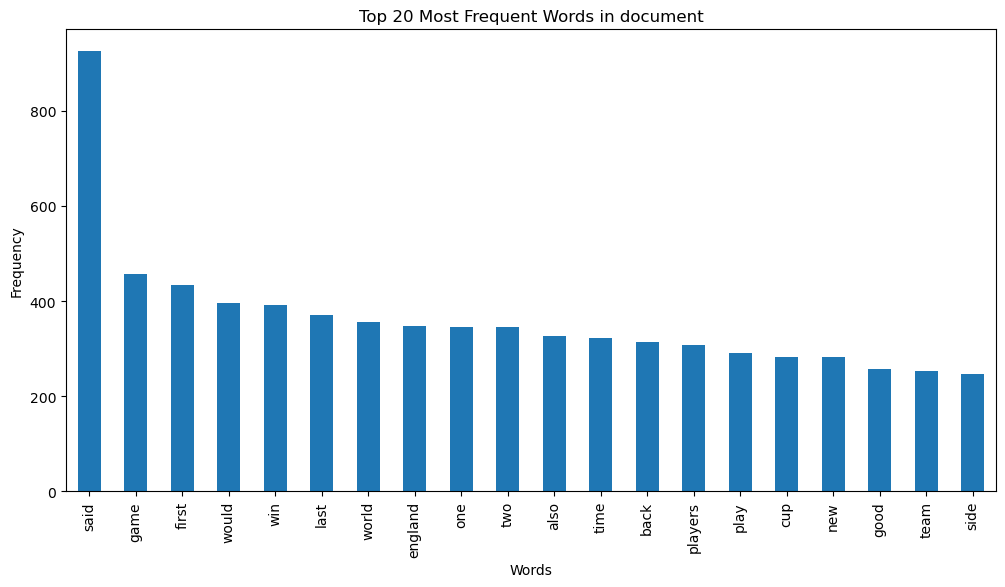

In [64]:
all_words = pd.Series(' '.join(data_sp['text']).lower().split())
word_counts = all_words.value_counts().sort_values(ascending=False)

num_words_to_visualize = 20

plt.figure(figsize=(12, 6))
word_counts.head(num_words_to_visualize).plot(kind='bar')
plt.title(f'Top {num_words_to_visualize} Most Frequent Words in document')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [65]:
# находим оценку согласованности с разным количеством тем
for i in range(2,15):
    lsi = LsiModel(corpus_sp, num_topics=i, id2word=dictionary_sp)
    coherence_model = CoherenceModel(model=lsi, texts=texts_sp, dictionary=dictionary_sp, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.5067533791611124
Coherence score with 3 clusters: 0.5191615408408903
Coherence score with 4 clusters: 0.3594300100214323
Coherence score with 5 clusters: 0.4006838573161392
Coherence score with 6 clusters: 0.3759802242744101
Coherence score with 7 clusters: 0.4378129771083707
Coherence score with 8 clusters: 0.3705979224696253
Coherence score with 9 clusters: 0.3394101826883406
Coherence score with 10 clusters: 0.3857300763251511
Coherence score with 11 clusters: 0.41735960676870043
Coherence score with 12 clusters: 0.3734533655504884
Coherence score with 13 clusters: 0.37450844067927636
Coherence score with 14 clusters: 0.3764787214492209


Наибольшая согласованность тем при 2 кластерах. Для анализа будем брать - 5

In [93]:
%%time
lsi_sp = lsimodel.LsiModel(corpus=corpus_tfidf_sp, id2word=dictionary_sp, num_topics=5)

CPU times: total: 1.11 s
Wall time: 469 ms


Сформировано 5 кластеров. Чем выше число слова, тем выше распределение слова по теме.
0 - о чемпионате по рэгби в Англии
1 - о легкоатлете Кентерисе и о тесте на наркотики 
2 - новости о спортсменах kenteris, roddick, thanou
3 - новости футбола
4 - новости о спортсменах roddick, radcliffe, holmes

In [95]:
lsi_sp.show_topics(5)

[(0,
  '-0.117*"england" + -0.106*"wales" + -0.086*"ireland" + -0.080*"game" + -0.078*"rugby" + -0.077*"would" + -0.074*"world" + -0.074*"cup" + -0.074*"robinson" + -0.074*"williams"'),
 (1,
  '0.283*"kenteris" + 0.257*"thanou" + 0.232*"iaaf" + 0.231*"greek" + 0.173*"athens" + 0.162*"drugs" + 0.143*"tests" + 0.126*"charges" + 0.125*"athletics" + 0.120*"olympics"'),
 (2,
  '-0.153*"kenteris" + 0.150*"seed" + -0.144*"wales" + -0.137*"thanou" + 0.136*"open" + -0.131*"england" + -0.125*"greek" + -0.121*"ireland" + -0.120*"iaaf" + 0.118*"roddick"'),
 (3,
  '0.203*"liverpool" + 0.177*"chelsea" + 0.158*"gerrard" + 0.136*"league" + -0.130*"seed" + 0.128*"benitez" + 0.122*"mourinho" + 0.121*"club" + 0.118*"parry" + 0.113*"arsenal"'),
 (4,
  '-0.206*"indoor" + -0.172*"race" + -0.171*"holmes" + -0.150*"european" + 0.147*"seed" + -0.127*"jump" + -0.123*"olympic" + 0.116*"roddick" + -0.110*"radcliffe" + -0.108*"record"')]

In [69]:
lsi_sp[corpus_tfidf_sp]

После применения LSI видим на матрице, видно что большинство слов связаны друг с дргом по диагонали. Выше и ниже диагонали связь слов друг с другом уменьшается. В классе спорт связь слов с друг другом наименьшая из всех классов

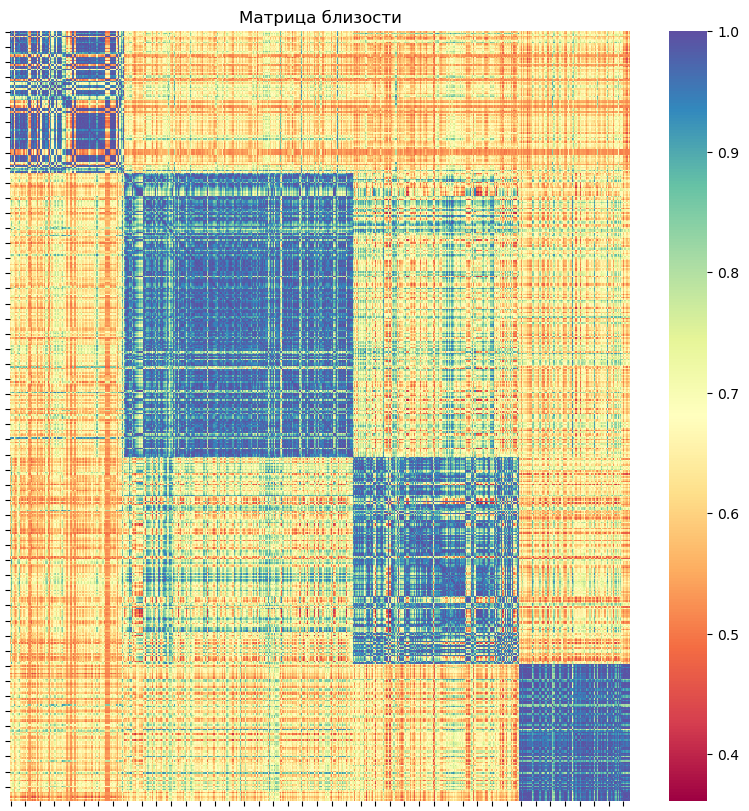

In [70]:
corpus_lsi_sp = lsi_sp[corpus_tfidf_sp] # каждый документ будет представлен в виде вектора, который характеризует его составность по темам.
index_sp_new = similarities.MatrixSimilarity(corpus_lsi_sp) #индекс для вычисления сходства между всеми документами в пространстве тем.
sims_sp_new = index_sp_new[corpus_lsi_sp]
sims_sp_new  = (sims_sp_new + 1)/2.

plt.figure(figsize = (10,10))
sns.heatmap(data=sims_sp_new, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

Класс tech

Построим гистограмму слов часто встречающихся в тексте. 
При анализе гистрограммы видим, часто встречающиеся слова относятся к классу politics: mobile, users, technology, software

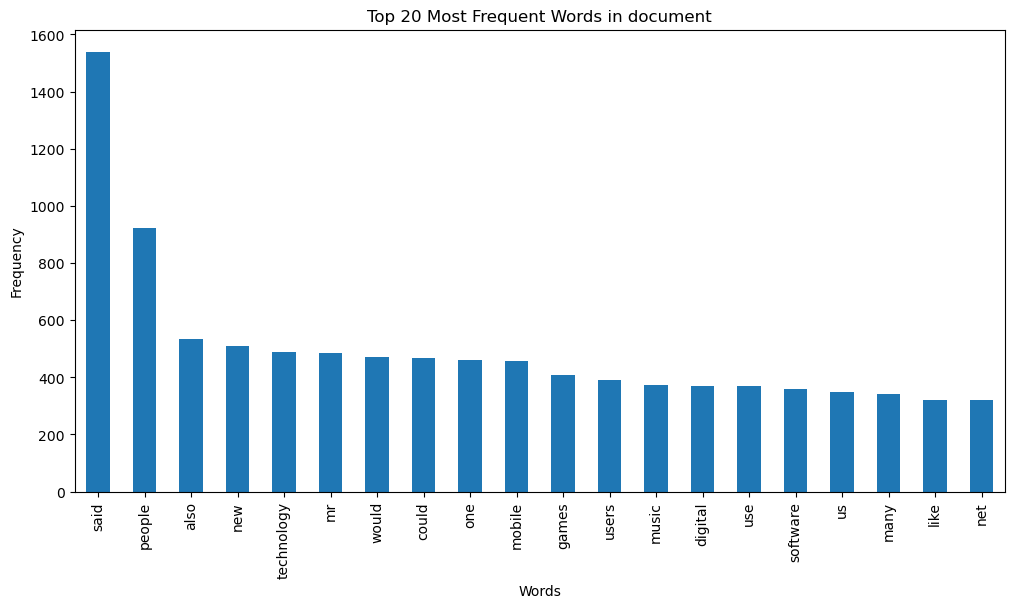

In [73]:
all_words = pd.Series(' '.join(data_tech['text']).lower().split())
word_counts = all_words.value_counts().sort_values(ascending=False)

num_words_to_visualize = 20

plt.figure(figsize=(12, 6))
word_counts.head(num_words_to_visualize).plot(kind='bar')
plt.title(f'Top {num_words_to_visualize} Most Frequent Words in document')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [74]:
# находим оценку согласованности с разным количеством тем
for i in range(2,15):
    lsi = LsiModel(corpus_tech, num_topics=i, id2word=dictionary_tech)
    coherence_model = CoherenceModel(model=lsi, texts=texts_tech, dictionary=dictionary_tech, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.3442318155610104
Coherence score with 3 clusters: 0.43909754315097577
Coherence score with 4 clusters: 0.38719859155056235
Coherence score with 5 clusters: 0.42395152716457496
Coherence score with 6 clusters: 0.38542086588279006
Coherence score with 7 clusters: 0.3589848208611307
Coherence score with 8 clusters: 0.3210089212642043
Coherence score with 9 clusters: 0.3866260244117844
Coherence score with 10 clusters: 0.37984597871843334
Coherence score with 11 clusters: 0.3514277594144612
Coherence score with 12 clusters: 0.31440637907340546
Coherence score with 13 clusters: 0.32154586217121606
Coherence score with 14 clusters: 0.3226734183342893


Наибольшая согласованность тем при 2 кластерах. Для анализа будем брать - 5

In [76]:
%%time
lsi_tech = lsimodel.LsiModel(corpus=corpus_tfidf_tech, id2word=dictionary_tech, num_topics=5)

CPU times: total: 1.16 s
Wall time: 530 ms


Сформировано 5 кластеров. Чем выше число слова, тем выше распределение слова по теме.
0 - мобильные телефоны, доступ к музыке играм, тв
1 - вирусные программы, как получение в спаме по email
2 и 4 - новости об игровых консолях -nintendo
3 - google поиск, jeeves, yahoo, вирусное ПО
4 - носости о Apple(mac, ipod )

In [77]:
lsi_tech.show_topics(5)

[(0,
  '-0.156*"mobile" + -0.120*"music" + -0.107*"broadband" + -0.107*"games" + -0.105*"phone" + -0.100*"tv" + -0.095*"phones" + -0.092*"digital" + -0.086*"search" + -0.082*"game"'),
 (1,
  '0.200*"security" + 0.180*"search" + 0.166*"spyware" + 0.151*"software" + 0.139*"virus" + 0.137*"spam" + 0.137*"email" + 0.132*"programs" + 0.127*"windows" + -0.124*"ds"'),
 (2,
  '0.226*"ds" + 0.217*"nintendo" + -0.205*"mobile" + -0.187*"broadband" + 0.181*"games" + 0.160*"game" + -0.153*"phone" + 0.148*"console" + 0.146*"handheld" + 0.137*"psp"'),
 (3,
  '-0.548*"search" + -0.193*"google" + -0.161*"desktop" + -0.150*"jeeves" + -0.146*"yahoo" + 0.146*"mobile" + 0.130*"security" + -0.121*"results" + 0.117*"spyware" + 0.115*"virus"'),
 (4,
  '-0.189*"broadband" + -0.183*"ds" + -0.168*"nintendo" + 0.154*"apple" + -0.144*"bt" + 0.135*"music" + 0.135*"dvd" + 0.131*"mac" + 0.114*"ipod" + -0.111*"handheld"')]

In [80]:
lsi_tech[corpus_tfidf_tech]

После применения LSI видим на матрице, видно что большинство слов связаны друг с дргом

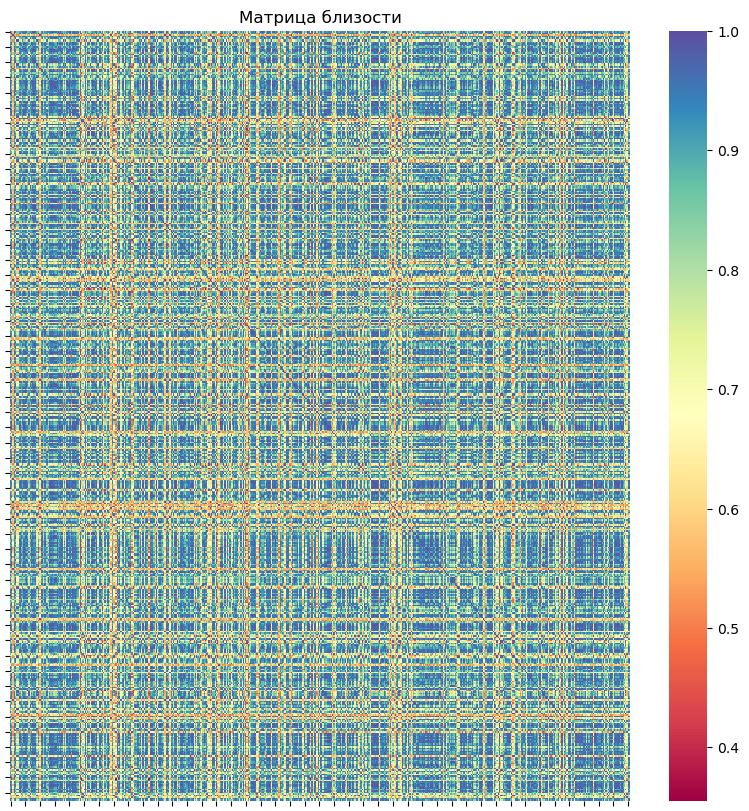

In [82]:
corpus_lsi_tech = lsi_tech[corpus_tfidf_tech] # каждый документ будет представлен в виде вектора, который характеризует его составность по темам.
index_tech_new = similarities.MatrixSimilarity(corpus_lsi_tech) #индекс для вычисления сходства между всеми документами в пространстве тем.
sims_tech_new = index_tech_new[corpus_lsi_tech]
sims_tech_new  = (sims_tech_new + 1)/2.

plt.figure(figsize = (10,10))
sns.heatmap(data=sims_bus_new, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()